# Bank Marketing Analysis (Machine Learning PySpark and MLlib)

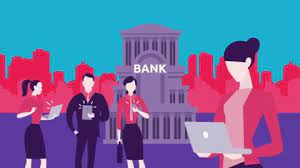

In [2]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 70kB/s 
     |████████████████████████████████| 204kB 19.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=c7fac1b2db1e84d49e57e71c5d13e9d8e698e67da371d713b7d9a7c838582f63
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('bank').getOrCreate()
df = spark.read.csv('/content/bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [5]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

### Our Classes are perfect balanced

In [8]:
df.groupby('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



### Summary statistics for numeric variables

In [10]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|               day|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|15.658036194230425|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev|11.913369192215518| 3225.413325946149| 8.420739541006462|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                18|             -6847|                 1|                 2|                 1|                -1|                 0|

In [12]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Preparing Data for Machine Learning

Category Indexing, One-Hot Encoding and VectorAssembler - a feature transformer that merges multiple columns into a vector column.

In [14]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

The above code are taken from databricks' official site and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. 

### Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [15]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [18]:
df.take(5)

[Row(label=1.0, features=SparseVector(30, {3: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 59.0, 25: 2343.0, 26: 1042.0, 27: 1.0, 28: -1.0}), age=59, job='admin.', marital='married', education='secondary', default='no', balance=2343, housing='yes', loan='no', contact='unknown', duration=1042, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes'),
 Row(label=1.0, features=SparseVector(30, {3: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 56.0, 25: 45.0, 26: 1467.0, 27: 1.0, 28: -1.0}), age=56, job='admin.', marital='married', education='secondary', default='no', balance=45, housing='no', loan='no', contact='unknown', duration=1467, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes'),
 Row(label=1.0, features=SparseVector(30, {2: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 41.0, 25: 1270.0, 26: 1389.0, 27: 1.0, 28: -1.0}), age=41, job='technician', marital='married', education='secondary', defa



Randomly split data into train and test sets. set seed for reproducibility

In [19]:
train, test = df.randomSplit([0.7, 0.3], seed = 20)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7831
Test Dataset Count: 3331


### Logistic Regression Model

In [20]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

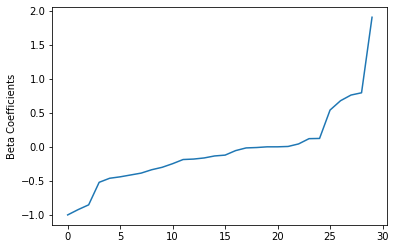

In [21]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Obtain the receiver-operating characteristic and areaUnderROC

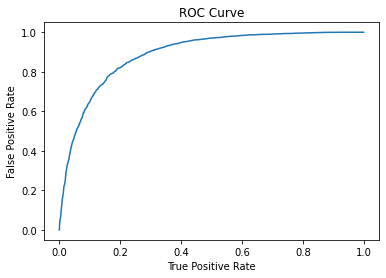

Training set areaUnderROC: 0.8888721156766819


In [22]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Precision and Recall

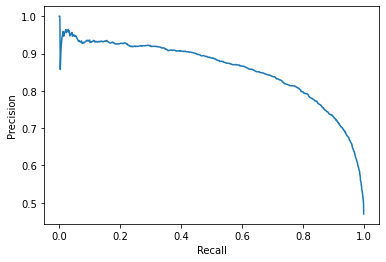

In [23]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Set the model threshold to maximize F-Measure

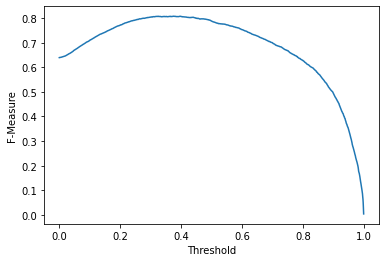

In [24]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

Make predictions on the test set

In [25]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[1.96845374172963...|       0.0|[0.87744493281539...|
| 52|management|  0.0|[-0.7582294615119...|       1.0|[0.31903079264827...|
| 58|management|  0.0|[2.83414555825610...|       0.0|[0.94449333665745...|
| 61|management|  0.0|[0.96824577286199...|       0.0|[0.72476970506385...|
| 36|management|  0.0|[0.95995095781919...|       0.0|[0.72311198595530...|
| 38|management|  0.0|[0.11710905866845...|       0.0|[0.52924385016178...|
| 56|management|  0.0|[2.97183729052417...|       0.0|[0.95128549025780...|
| 33|management|  0.0|[2.94562408262224...|       0.0|[0.95005626240302...|
| 34|management|  0.0|[1.29177314600250...|       0.0|[0.78444716131969...|
| 39|management|  0.0|[1.19344018775443...|       0.0|[0.76735577438380...|
+---+-------

Evaluate our Logistic Regression model

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8779282332466435


In [27]:
evaluator.getMetricName()

'areaUnderROC'

## ParamGridBuilder and the CrossValidator.

In [28]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8780256816152486


In [29]:
evaluator.getMetricName()

'areaUnderROC'

### Decision Tree Classifier


In [30]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 35|management|  0.0|[806.0,1231.0]|       1.0|[0.39567992145311...|
| 52|management|  0.0|[410.0,1789.0]|       1.0|[0.18644838562983...|
| 58|management|  0.0|[2509.0,461.0]|       0.0|[0.84478114478114...|
| 61|management|  0.0|[2509.0,461.0]|       0.0|[0.84478114478114...|
| 36|management|  0.0|  [381.0,29.0]|       0.0|[0.92926829268292...|
| 38|management|  0.0|[410.0,1789.0]|       1.0|[0.18644838562983...|
| 56|management|  0.0|[2509.0,461.0]|       0.0|[0.84478114478114...|
| 33|management|  0.0|[2509.0,461.0]|       0.0|[0.84478114478114...|
| 34|management|  0.0|[806.0,1231.0]|       1.0|[0.39567992145311...|
| 39|management|  0.0|[2509.0,461.0]|       0.0|[0.84478114478114...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

Evaluate our Decision Tree model

In [31]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7653006570907404


In [32]:
evaluator.getMetricName()

'areaUnderROC'

### Random Forest Classifier

In [33]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[11.6826491565660...|       0.0|[0.58413245782830...|
| 52|management|  0.0|[6.76151386895772...|       1.0|[0.33807569344788...|
| 58|management|  0.0|[14.7875490703257...|       0.0|[0.73937745351628...|
| 61|management|  0.0|[8.11170549659424...|       1.0|[0.40558527482971...|
| 36|management|  0.0|[15.6837449789468...|       0.0|[0.78418724894734...|
| 38|management|  0.0|[11.2768666241881...|       0.0|[0.56384333120940...|
| 56|management|  0.0|[16.5262296952490...|       0.0|[0.82631148476245...|
| 33|management|  0.0|[15.5969230090585...|       0.0|[0.77984615045292...|
| 34|management|  0.0|[12.1391199827933...|       0.0|[0.60695599913966...|
| 39|management|  0.0|[13.6689213205597...|       0.0|[0.68344606602798...|
+---+-------

In [34]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8799710397885296


In [35]:
evaluator.getMetricName()

'areaUnderROC'

In [36]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

### Gradient-boosted Tree Classifier

In [37]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[0.01682559065166...|       0.0|[0.50841200152686...|
| 52|management|  0.0|[-0.6211891589025...|       1.0|[0.22402227642440...|
| 58|management|  0.0|[1.29272834739567...|       0.0|[0.92991971198451...|
| 61|management|  0.0|[-0.5031407767736...|       1.0|[0.26770818696320...|
| 36|management|  0.0|[1.01423222487108...|       0.0|[0.88375341870001...|
| 38|management|  0.0|[0.16831130119054...|       0.0|[0.58336988010861...|
| 56|management|  0.0|[1.29886298353932...|       0.0|[0.93071508329252...|
| 33|management|  0.0|[1.22951248655661...|       0.0|[0.92121892968591...|
| 34|management|  0.0|[0.41386840111175...|       0.0|[0.69587617600586...|
| 39|management|  0.0|[0.96042671357464...|       0.0|[0.87223357166988...|
+---+-------

In [38]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8815986080041944


In [39]:
evaluator.getMetricName()

'areaUnderROC'

Gradient-boosted Tree achieved the best results, we will try tuning this model with the ParamGridBuilder and the CrossValidator.

In [40]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [42]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.88498078823459